# LL Transport

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dgutils import colors as col
import dgutils

import matplotlib.patheffects as path_effects

from numpy import pi as π
from scipy import integrate
from scipy.constants import hbar as ħ
from scipy.constants import k
from scipy.special import ellipe
from scipy.special import ellipk
import numpy.ma as ma
import os


# Notebook display options
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle', 
              'sans':'../include/sans.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])

figsize = plt.rcParams['figure.figsize']

π = np.pi
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Load data from disk

This data was generated via Mathematica and can be found in the file `{}.nb`

In [2]:
K = [1.1,1.2,1.3,1.5,1.8,2.5]
data = {}
for cK in K:
    Kval = str(cK).replace('.','')
    fname = f'plotdata_K={Kval}.dat'
    data[str(cK)] = np.loadtxt(f'../data/{fname}')
    
Kcolors = dgutils.colors.get_linear_colors('Spectral',len(K))

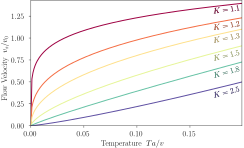

In [80]:
path_eff = [path_effects.withSimplePatchShadow(offset=(0.06, -0.06), shadow_rgbFace='k', alpha=1.0)]
from matplotlib import ticker

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    factor = [0.99,0.978,0.97,0.96,0.95,0.92]
    angle = [7,9,11,13,15,14]
    
    for i,cK in enumerate(K):
        ax.plot(data[str(cK)][:,0],data[str(cK)][:,1],color=Kcolors[i], lw=1)
        ax.text(0.20,factor[i]*data[str(cK)][-1,1],f'$K={cK}$', ha='right',va='top', color=Kcolors[i],
                              fontsize=8,path_effects=path_eff, rotation=angle[i])
    
    ax.set_xlim(0,0.199);
    ax.set_ylim(0,1.43)
    
    ax.set_xlabel(r'Temperature   $\;T a / v$')
    ax.set_ylabel(r'Flow Velocity $\;v_s/v_0$')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    plt.savefig('../figures/LL_transport.pdf')